In [1]:
from glob import glob

import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [2]:
data_set = pd.DataFrame()
for fpath in glob('data/*/reuters-*.json'):
    df = pd.read_json(fpath).T
    data_set = data_set.append(df)
    
data_set = data_set.fillna('')
print('Done!')

Done!


# Exploratory Data Analysis
our first task is to take a close look at the dataaet by loading and performing ex-ploratory data analysis. To do so, we must extract metadata and the text body from each document in the corpus. If we take a close look at the corpus, we find some interesting facts. Run the next three cells to visualize the results.

documents with at least one topic =  11367
max number of topics in one document =  16
number of topics =  120
number of places =  147
number of organizations =  32


<AxesSubplot:title={'center':'Dcoument Count by Organization'}>

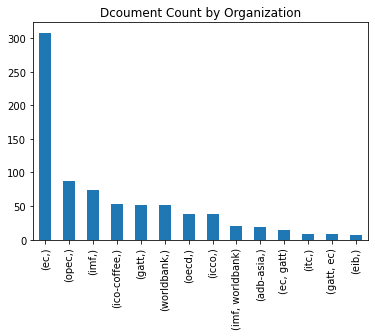

In [3]:
# getting elements using double loops
topics = set([x for sublist in data_set[u'topics'].values.tolist() for x in sublist])
places = set([x for sublist in data_set[u'places'].values.tolist() for x in sublist])
orgs = set([x for sublist in data_set[u'organisations'].values.tolist() for x in sublist])

data_set['topic_count'] = data_set[u'topics'].apply(lambda x: len([y for y in x]))
print("documents with at least one topic = ", len(data_set[data_set[u'topic_count']>0]))
print("max number of topics in one document = ", data_set[u'topic_count'].max())
print("number of topics = ", len(topics))
print("number of places = ", len(places))
print("number of organizations = ", len(orgs))

# 1:15 to get rid of none
data_set[u'organisations'].apply(tuple).value_counts()[1:15].plot(kind='bar',
                                                                  title='Dcoument Count by Organization')

<AxesSubplot:title={'center':'Document Count by Places outside US'}>

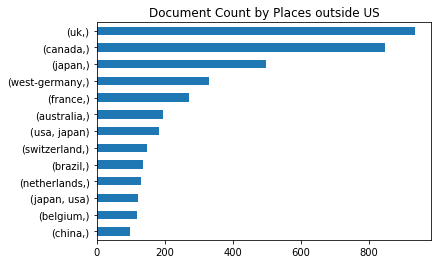

In [4]:
# 2:15 to get rid of us and none 
data_set[u'places'].apply(tuple).value_counts()[2:15].sort_values().plot(kind='barh',
                                                                        title='Document Count by Places outside US')

<AxesSubplot:title={'center':'Document Cont by Topic'}>

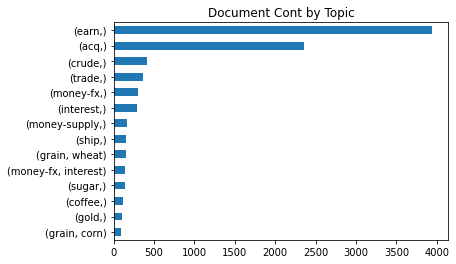

In [9]:
# # 1:15 to get rid of none
data_set[u'topics'].apply(tuple).value_counts()[1:15].sort_values().plot(kind='barh',
                                                                        title='Document Cont by Topic')

So far so good. But before we perform any NLP analysis, we will want to perform some text normalization:

- transform to lower case
- remove punctuation & numbers
- stem verbs
- remove stopwords

To do so, we define a Simple Tokenizer method that will be useful when creating document representations. For our analysis, we will analyze documents involving five topics (cocoa, trade, money-fx, coffe, and gold).

In [21]:
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#from sklearn.preprocessing.label import MultiLabelBinarizer
from sklearn.preprocessing._label import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("punkt")
nltk.download("stopwords", "data")
nltk.data.path.append('data')

label_binarizer = MultiLabelBinarizer()
data_target = label_binarizer.fit_transform(data_set[u'topics'])

stop_words = stopwords.words('english')
charfilter = re.compile('[a-zA-Z]+')

def simple_tokenizer(text):
    # transform to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    # remove stopwords
    words = [word for word in words if word not in stop_words]
    # stem verbs
    tokens = (list(map(lambda token: PorterStemmer().stem(token), words)))
    # # remove punctuation & numbers
    ntokens = list(filter(lambda token: charfilter.match(token), tokens))
    return ntokens

vec = TfidfVectorizer(tokenizer=simple_tokenizer,
                      max_features=1000,
                      norm='l2')

mytopics = [u'cocoa', u'trade', u'money=supply', u'coffe', u'gold']
data_set = data_set[data_set[u'topics'].map(set(mytopics).intersection).apply(lambda x: len(x)>0)]
docs = list(data_set[u'body'].values)

dtm = vec.fit_transform(docs)

print("Number of documents with my topics = ", len(data_set))

[nltk_data] Downloading package punkt to /home/masao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to data...
[nltk_data]   Package stopwords is already up-to-date!


Number of documents with my topics =  760


# Text Clustering